In this demo, we compute word-level explanations for the Huggingface [`textattack/roberta-base-SST-2`](https://huggingface.co/textattack/roberta-base-SST-2) model, also the setup presented in the paper.

We first load required packages and the RoBERTa model. Two classes are needed to compute the explanations. `BeamSearchExplainer` implements the beam search algorithm, and `*Masker` implements the feature masking. In this demo, we use `TextWordMasker` since we need to mask out individual words from a text input. The other demos showcase other `*Maskers`.

In [1]:
from solvex import BeamSearchExplainer, TextWordMasker
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification

device = 'cuda' if torch.cuda.is_available() else 'cpu'
name = 'textattack/roberta-base-SST-2'
tokenizer = AutoTokenizer.from_pretrained(name)
model = AutoModelForSequenceClassification.from_pretrained(name).to(device).eval()

Some weights of the model checkpoint at textattack/roberta-base-SST-2 were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


The explainer expects the function to be explained in a particular format. Specifically, it takes in a list of `N` (full or masked) inputs, and returns a `numpy` array of shape `N x C` where `C` is the number of classes. The values of the array can be anything, but most commonly the class probability, which is what we are going to do here. In addition, when masking features (i.e., words) from a piece of text, `TextWordMasker` expects the text to be a pre-tokenized list of words and returns another list of words. Thus, `sentences` is a list in which each element is a list of words and the function below needs to `join` each sentence back to a string.

In [2]:
def model_func(sentences):
    sentences = [' '.join(s) for s in sentences]
    tok = tokenizer(sentences, return_tensors='pt', padding=True).to(device)
    with torch.no_grad():
        logits = model(**tok)['logits']
    probs = torch.nn.functional.softmax(logits, dim=-1).cpu().numpy()
    return probs

Now we are ready to explain! We instantiate the explainer, prepare the input sentence (as a list of words), and call the `explain_instance` function. The `suppression` argument passed to `TextWordMasker` tells the masker how to mask out a word. In this case, we simply delete it. The label argument to `explain_instance` specifies which `label` we want to generate the explanation for. In our case, we want to explain the positive class, which is label `1`. If it is not specified, the label with the highest function value will be used.

In [3]:
sentence = 'A triumph , relentless and beautiful in its downbeat darkness .'.split(' ')
masker = TextWordMasker(suppression='remove')
explainer = BeamSearchExplainer(masker, f=model_func, beam_size=50, batch_size=50)
e = explainer.explain_instance(sentence, label=1)

100%|█████████████████████████████████| 11/11 [00:00<00:00, 23.65it/s]


The explanation `e` we get is a dictionary of keys `'exp'`, `'label'` and `'func_val'`, of type `list`, `int` and `float` respectively, as printed out below.

In [4]:
print(e)

{'exp': [1.5, 8.5, 3.5, 2.5, 4.5, 9.5, 5.5, 7.5, 6.5, -0.5, 0.5], 'label': 1, 'func_val': 0.9996933}


Even better, all built-in `*Masker` classes include more user-friendly explanation displays, and the `TextWordMasker` class has three. They can be called with `masker.render_result`, using different `mode` parameters. The first one is console printing.

In [5]:
masker.render_result(sentence, e, mode='text', execute=True)

Input: A triumph , relentless and beautiful in its downbeat darkness .
Explained label: 1
Function value for label 1: 1.000
Word feature attribution:
+------------+------------+
| Word       |   Attr val |
|------------+------------|
| A          |        1.5 |
| triumph    |        8.5 |
| ,          |        3.5 |
| relentless |        2.5 |
| and        |        4.5 |
| beautiful  |        9.5 |
| in         |        5.5 |
| its        |        7.5 |
| downbeat   |        6.5 |
| darkness   |       -0.5 |
| .          |        0.5 |
+------------+------------+


The second one is color rendering.

In [6]:
masker.render_result(sentence, e, mode='color', execute=True)

It writes an HTML snippet to a file named `explanation.html`, which is rendered below.
<div style="border: solid; border-width: 1px; margin-top: 5px; margin-bottom: 5px; padding-left: 10px; padding-right: 10px; padding-bottom: 5px;">Explained label: 1<br>Function value for label 1: 1.000<br><pre style="white-space: pre-wrap; margin: 0px;"><span style="background-color: rgb(222, 204, 200);">A</span> <span style="background-color: rgb(230, 129, 106);">triumph</span> <span style="background-color: rgb(225, 183, 173);">,</span> <span style="background-color: rgb(223, 194, 187);">relentless</span> <span style="background-color: rgb(226, 172, 160);">and</span> <span style="background-color: rgb(232, 119, 93);">beautiful</span> <span style="background-color: rgb(227, 161, 146);">in</span> <span style="background-color: rgb(229, 139, 119);">its</span> <span style="background-color: rgb(228, 151, 133);">downbeat</span> <span style="background-color: rgb(215, 217, 222);">darkness</span> <span style="background-color: rgb(221, 215, 214);">.</span> </pre></div>
The last one is plotting.

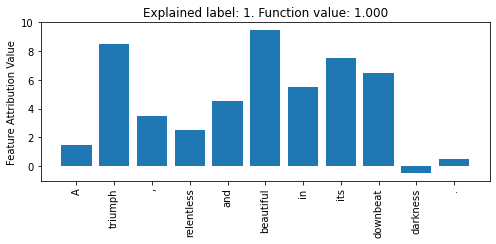

In [7]:
masker.render_result(sentence, e, mode='plot', execute=True)

And that's it! Want to learn more? Check out the other tabs for more use cases. If you want to gain a deeper understanding of the `*Masker` classes and implement your own, check out this jupyter notebook for an example where we build one from scratch and browse the documentations. Bugs? Suggestions? Questions? Ask away on [GitHub](https://github.com/YilunZhou/solvability-explainer)!